# 使用合成控制法对比黄河的水资源利用陷阱

大概的步骤：
- 加载数据
- 确定数据中 Predictors 和 Outcome，区分 observation 和控制变量
- 确定探索的时间点
- 将数据转化为 long panel-data
- 加载相关的包，进行试验
- 分析试验结果，找寻替代方案

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [3]:
%load_ext rpy2.ipython

## 使用九大流域的数据

In [4]:
basins = pd.read_csv("../data/perfectures/basins/all_basins.csv", index_col=0)
basins.head()

,Year,Irrigated area: Total,Irrigated area: Rice,Irrigated area: Wheat,Irrigated area: Maize,Irrigated area: Vegetables and fruits,Irrigated area: Others,Industrial gross value added (GVA): Total,Industrial gross value added (GVA): Textile,Industrial gross value added (GVA): Papermaking,...,Industrial gross value added (GVA): Electronics,Industrial gross value added (GVA): Thermal electrivity,Industrial gross value added (GVA): Others,Urban population,Service GVA,Rural population,Livestock population,Total water use,Basin,Index
0,1965,15179.144480,6824.293811,1691.520309,892.008327,401.316161,5370.005871,46.073883,10.864801,0.317696,...,0.326080,0.155531,26.328120,49.045544,19.716284,252.858972,36775.598590,118.719052,changjiang,0
1,1966,14849.450091,6759.463094,1655.738660,924.242646,383.201109,5126.804583,58.128028,12.389268,0.370584,...,0.388020,0.188389,35.144641,50.753820,19.938745,265.044105,37575.045643,119.943611,changjiang,0
2,1967,14869.257256,6553.094603,1879.252203,922.005897,389.550903,5125.353649,47.864066,12.422250,0.407818,...,0.410414,0.222298,23.987950,52.535439,20.304432,277.032200,38524.930887,119.890597,changjiang,0
3,1968,15058.741376,6791.004372,1857.457216,921.563887,409.874297,5078.841604,42.420497,16.912281,0.583586,...,0.629718,0.315902,18.303204,54.393999,21.551910,288.335391,39552.146395,121.764370,changjiang,0
4,1969,15023.339589,6742.221420,1893.320685,922.326833,394.373503,5071.097147,55.498867,13.961525,0.556265,...,0.526410,0.325946,26.805917,56.333298,25.133602,299.023290,40735.026733,125.071888,changjiang,0


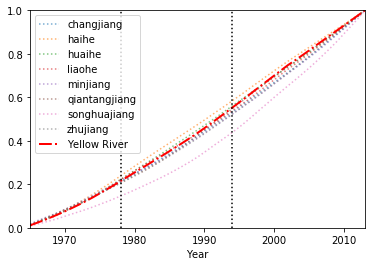

In [32]:
ture_data = pd.read_csv(r'../data/perfectures/yr/perfectures_in_YR_with_threshold_0.05.csv')
for basin, data in basins.groupby('Basin'):
    if basin == 'huanghe':
        continue
    twu = data.set_index('Year')['Total water use']
    pdf = twu.cumsum()/ twu.sum()
    pdf.plot(label=basin, alpha=0.6, ls=":")
yr_twu = ture_data.groupby("Year")["Total water use"].sum()
(yr_twu.cumsum()/yr_twu.sum()).plot(label='Yellow River', ls='-.', color='red', lw=2)
plt.axvline(1978, color='black', ls=":")
plt.axvline(1994, color='black', ls=":")
plt.xlim(1965, 2013)
plt.ylim(0, 1)
plt.legend()
plt.show();

In [57]:
r_script = """

# Load package
library(Synth)

# Load Data 
myd <- read.csv("../data/perfectures/basins/all_basins.csv")
myd$Basin <- as.character(myd$Basin)

## pick v by cross-validation
# data setup for training model
dataprep.out <-
  dataprep(
           foo = myd,
           predictors    = c({predictor}),
           dependent     = "{outcome}",
           unit.variable = "{unit_variable}",
           time.variable = "{time_variable}",
           treatment.identifier = {treatment},
           controls.identifier = c({controls}),
           time.predictors.prior = {before},
           time.optimize.ssr = {after},
           unit.names.variable = {region_names},
           time.plot = {time_plot}
         )

# fit training model
synth.out <- 
  synth(
        data.prep.obj=dataprep.out
        )


actual_data <- dataprep.out$Y1plot
synth_data <- dataprep.out$Y0plot %*% synth.out$solution.w 

out_list <- list(
  y1 = actual_data,
  y0 = synth_data
)
"""

In [48]:
def formula_synth_data(data, predictors, time_col, index_col, treatment_year, treatment_index, unit_name_col, how='whole', periods=None):
    """利用合成控制法来分析数据
    data: 用来合成的数据,
    predictors: 一个所有的合成变量，其中第一个变量是预测变量,
    time_col: 标明时间的列,
    index_col: 标明处理索引的列,
    treatment_year: 处理的时间点,
    treatment_index: 处理的区域
    """
    import re
    
    def add_list_to_str(a_list, quotation=True):
        a_str = ""
        for i, item in enumerate(a_list):
            if i+1 == len(a_list):
                if quotation:
                    a_str += '"{}"'.format(item)
                else:
                    a_str += "{}".format(item)
            else:
                if quotation:
                    a_str += '"{}", '.format(item)
                else:
                    a_str += '{}, '.format(item)
        return a_str
    

    # 预测变量
    predictors = [re.sub(r"[: ()]", ".", item) for item in predictors]  # 转化为 R 脚本的表达

    # 输出变量
    outcome = predictors[0]

    # 不对预测具有帮助的变量
    for unpredicted_col in [outcome, time_col, index_col, unit_name_col]:
        if unpredicted_col in predictors:
            predictors.remove(unpredicted_col) 

    # 将预测变量格式化为输入R脚本的形式
    predictor = add_list_to_str(predictors)


    # 时间变量变量列
    if periods:
        start_year, end_year = periods
    else:
        start_year, end_year = data[time_col].min(), data[time_col].max()
    before = "{}:{}".format(start_year, treatment_year)
    after = "{}:{}".format(treatment_year+1, end_year)
    time_plot = "{}:{}".format(start_year, end_year)

    # 区域处理
    controls = data[index_col].unique().tolist()
    controls.remove(treatment_index)
    controls = add_list_to_str(controls, quotation=False)
    region_names = '"{}"'.format(unit_name_col)

    format_script = r_script.format(
        predictor=predictor,
        outcome=outcome,
        time_variable=time_col,
        unit_variable=index_col,
        treatment=treatment_index,
        controls=controls,
        before=before,
        after=after,
        region_names=region_names,
        time_plot=time_plot,
    )
    
    with open(r"../scripts/formula_script.R", 'w') as f:
        f.write(format_script)
    return format_script

In [52]:
def run_synth_and_plot(predictors, outcome, treat_year, ax=None, plot=True, **kargs):
    from rpy2 import robjects as ro

    def clean_predictors(list_, item):
        list_.remove(item)
        list_.insert(0, item)
        return list_

    predictors = clean_predictors(predictors, outcome)  # 将预测变量置顶

    script = formula_synth_data(
        data=basins, 
        predictors=predictors, 
        time_col='Year', 
        index_col='Index', 
        treatment_year=treat_year, 
        treatment_index=3,
        unit_name_col="Basin",
        periods=kargs['periods']
    )
    
    result = ro.r(script)

    # 绘图：
    if plot:
        if ax is None:
            fig, ax = plt.subplots()

        y0 = result[0]
        y1 = result[1]

        if kargs['periods']:
            x = np.arange(periods[0], periods[1]+1)
        else:
            x = np.array(basins['Year'].unique())
        ax.plot(x, y0, label='Actual')
        ax.plot(x, y1, label="Synth")
        ax.axvline(x=treat_year, ls=":", color='red', label='treatment: {}'.format(treat_year))
        ax.legend()

    return result[1]

## 预测流域总用水量

In [36]:
all_predictors = basins.columns.tolist()
major_predictors = ['Irrigated area: Total', 'Industrial gross value added (GVA): Total']
major_predictors.extend(all_predictors[-7:])
major_predictors

['Irrigated area: Total',
 'Industrial gross value added (GVA): Total',
 'Urban population',
 'Service GVA',
 'Rural population',
 'Livestock population',
 'Total water use',
 'Basin',
 'Index']

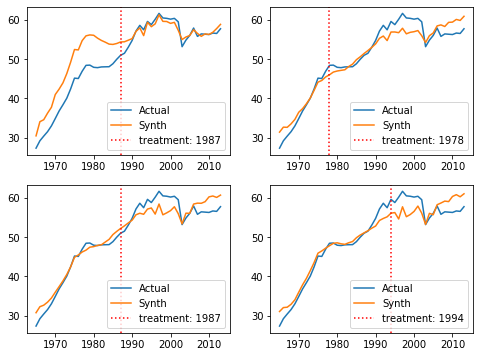

In [37]:
fig, ((ax1, ax2),(ax3, ax4)) = plt.subplots(2, 2, figsize=(8, 6))
result = run_synth_and_plot(all_predictors, 'Total water use', ax=ax1, treat_year=1987)
result2 = run_synth_and_plot(major_predictors, 'Total water use', ax=ax2, treat_year=1978)
result3 = run_synth_and_plot(major_predictors, 'Total water use', ax=ax3, treat_year=1987)
result4 = run_synth_and_plot(major_predictors, 'Total water use', ax=ax4, treat_year=1994)

In [4]:
predictions = pd.read_csv("../data/synth_repeat_predictions.csv", index_col=0)

predictions.head()

,1978,1979,1980,1981,1982,1983,1984,1985,1986,1987,1988,1989,1990,1991,1992,1993
1965,31.381230,31.397044,31.358359,31.354031,31.335913,31.312353,31.320391,31.373105,31.307583,30.768014,30.887667,31.510223,31.246558,31.390169,30.646129,31.116608
1966,32.675897,32.725898,32.740372,32.777881,32.795115,32.803292,32.832512,32.891602,32.855557,32.295414,32.297907,33.073105,32.332269,32.973409,32.241110,32.187752
1967,32.646871,32.694552,32.720387,32.767709,32.793380,32.808974,32.843331,32.903760,32.874817,32.684179,32.609567,33.095746,32.553014,33.064058,32.674526,32.345912
1968,33.522015,33.595781,33.641130,33.702927,33.740466,33.766844,33.808422,33.871885,33.852168,33.456138,33.367692,34.080782,33.370113,34.022273,33.453648,33.128804
1969,34.703333,34.748481,34.797290,34.865350,34.908301,34.938838,34.984394,35.049622,35.033386,34.495136,34.407341,35.268897,34.518718,35.189394,34.490509,34.273481


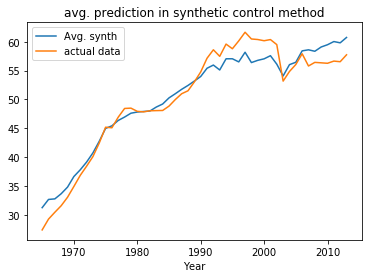

In [33]:
predictions.mean(axis=1).plot.line(label='Avg. synth')
actual_data = pd.read_csv("../data/perfectures/yr/perfectures_in_YR_with_threshold_0.05.csv")
actual_data = actual_data.groupby("Year")["Total water use"].sum()
actual_data.plot.line(label='actual data')
plt.title("avg. prediction in synthetic control method")
plt.legend();

## 分段进行预测

34.404306,34.013436,33.579139,33.599167,...,54.151904,55.573791,56.828660,58.573065


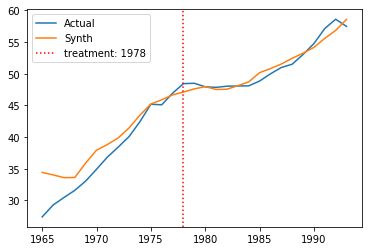

In [58]:
periods=(1965, 1993)
run_synth_and_plot(major_predictors, 'Total water use', treat_year=1978, periods=periods)

48.303740,48.909799,48.863431,49.011675,...,60.970015,60.752167,60.478075,60.614604


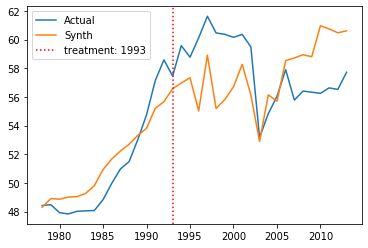

In [56]:
periods = (1978, 2013)
run_synth_and_plot(major_predictors, 'Total water use', treat_year=1993, periods=periods)